# 화합물 특성 예측 (용해도)

- RDKit과 DeepChem 라이브러리를 통해 다양한 기능을 사용해 본 후, 앞서 실습한 선형 회귀 모델을 활용하여 분자의 용해도를 예측하는 실습

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 12.5 MB/s 
     |████████████████████████████████| 29.5 MB 1.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
%config InlineBackend.figure_format = 'retina' 
warnings.filterwarnings("ignore")
%matplotlib inline

from rdkit import Chem 
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 데이터

- 소분자 유기화합물의 lipophilicity 데이터 (용해도) 사용

- **Lipophilicity** 는 화합물이 lipids, oils 등 비극성 용매에 용해되는 물리적 특성을 나타낸다

- 이는 분배 계수 distribution coefficent P로 표현된다
 - 물과 옥탄올에 대한 평형상태의 용해농도의 비률로 표현된다
 - P 값이 클수록 지질 친화성이 큰 것을 나타낸다 (보통 log10P를 사용한다)
 - 실험적으로 이 값을 구하려면 많은 노력이 필요하다. 머신러닝으로 용해도를 예측하는 모델을 만들업겠다 


In [ ]:
# 데이터 다운로드 (컬럼명을 'smiles'와 'logP'로 지정)
logP_data = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/logP_dataset.csv', 
            names=['smiles', 'logP'])

# csv 파일로 저장
logP_data.to_csv('logP.csv')

# 내용 보기
print(logP_data.shape)
logP_data[:3]

(14610, 2)


,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3


<Axes: >

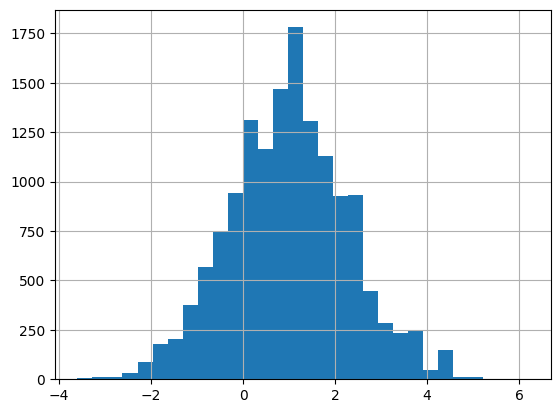

In [ ]:
# 목적 변수 분포
logP_data.logP.hist(bins=30)

## SMILES로부터 Mol 객체 얻기
- Chem.MolFromSmiles() 함수를 이용한다

In [ ]:
# 사본 데이터프레임 사용
df = logP_data.copy() 

In [ ]:
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

# 다른 방법
# df['mol'] = [Chem.MolFromSmiles(x) for x in df['smiles']] 
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


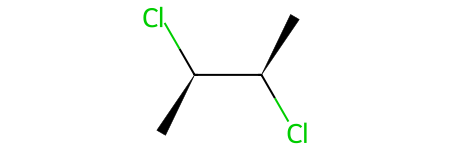

In [ ]:
df.mol[0]

## 시각화
- rdkit.Chem.Draw를 사용하여 mol 객체를 시각화할 수 있다
- Draw.MolsToGridImage()함수 사용

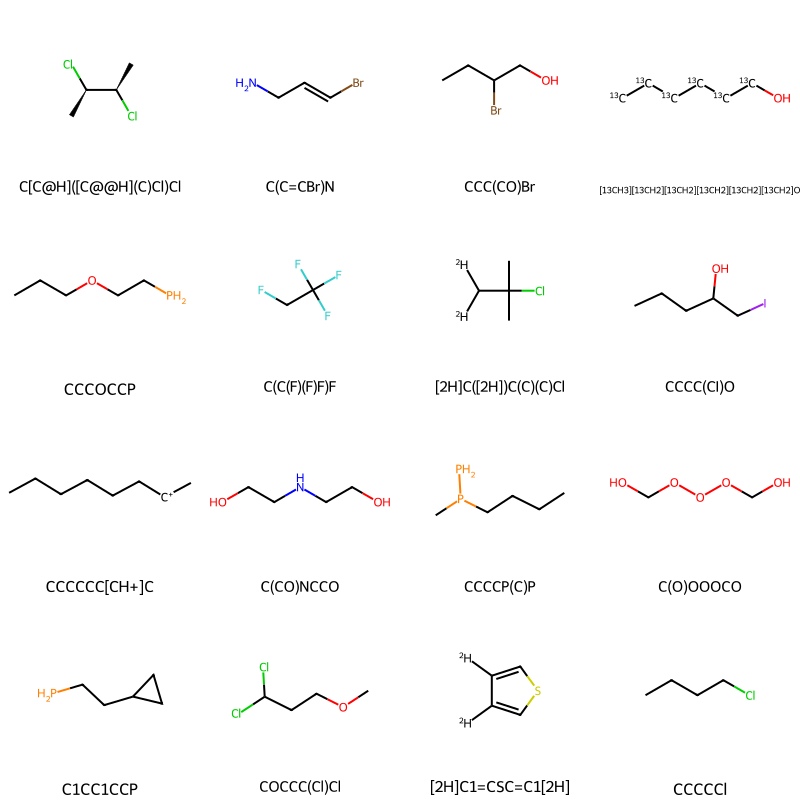

In [ ]:
# 16개 이미지를 그리드 형태로 그리기
mols = df['mol'][:16]
Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, legends=list(df['smiles'][:16].values))

## 분자 정보 보기

- Chem 모듈에서 다양한 정보 추출 함수를 제공한다
- 예를 들어 mol 객체로부터 분자를 구성하는 원자수를 얻으려면 다음과 같은 함수를 사용하면 된다
 - GetNumAtoms()
 - GetNumHeavyAtoms()
- mol 객체에 수소원자를 포함시키려면 AddHs()를 호출한다


In [ ]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x00000260BFA...,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x00000260BFA...,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x00000260BFA...,15,6


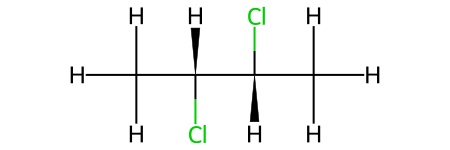

In [ ]:
df.mol[0]

## 특성 추가
- 분자내에 들어 있는 C, O 등 각 원자별 갯수를 특성으로 추가하겠다
- 이를 위해서 분자의 하부 구성을 찾는 GetSubstructMatches()를 사용한다

In [ ]:
# 탄소 패턴을 지정한다
c_patt = Chem.MolFromSmiles('C')

# 이 패턴이 들어있는 곳을 찾는다. 패턴의 수를 세면 탄소 원자가 몇개 들어있는지 알 수 있다
print(df['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (2,), (3,))


In [ ]:
# 임의의 패턴(원자)를 몇개 포함하고 있는지를 얻는 함수
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

In [ ]:
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x00000260BFA...,14,6,4,0,0,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x00000260BFA...,11,5,3,0,1,0
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x00000260BFA...,15,6,4,1,0,0


# 회귀 모델
- 위에서 구한 분자의 여러 특성을 사용하여 용해도를 예측한다

## 훈련/검증 데이터 나누기

In [ ]:
# 특성 컬럼을 선택하여 X를 만들고 목적변수를 정의한다
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

# 훈련과 검증 데이터를 나눈다 (검증 데이터로 10% 할당)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1)


Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


- 아래는 훈련과 검증 데이터를 나누는 개념도이다. 주어진 데이터 순서를 유지하면서 데이터를 나누려면 shuffle=False 옵션을 지정하면 된다 (디폴트 값은 랜덤하게 섞는다)

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202020-12-29%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2011.45.47.png?raw=1" width=300 align='left'>

- 회귀 모델의 여러 성능 평가 지표를 보는 함수 정의

In [ ]:
def show_reg_result(y_test, y_pred, N=50):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    R2 = r2_score(y_test, y_pred)
    max_err = np.abs(y_test - y_pred).max()
    
    print('R2:', round(R2,4))
    print('MAE:', round(mae, 4))
    print('RMSE:', round(rmse,4))
    print('Max error:', round(max_err, 4))

    # 일부 실제값과 예측값 샘플을 plot으로 비교하여 그려본다 (N 개)
    
    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel('logP')
      plt.show()  

## 선형모델

In [ ]:
X_train.columns

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')

R2: 0.6483
MAE: 0.5814
RMSE: 0.7649
Max error: 4.8522


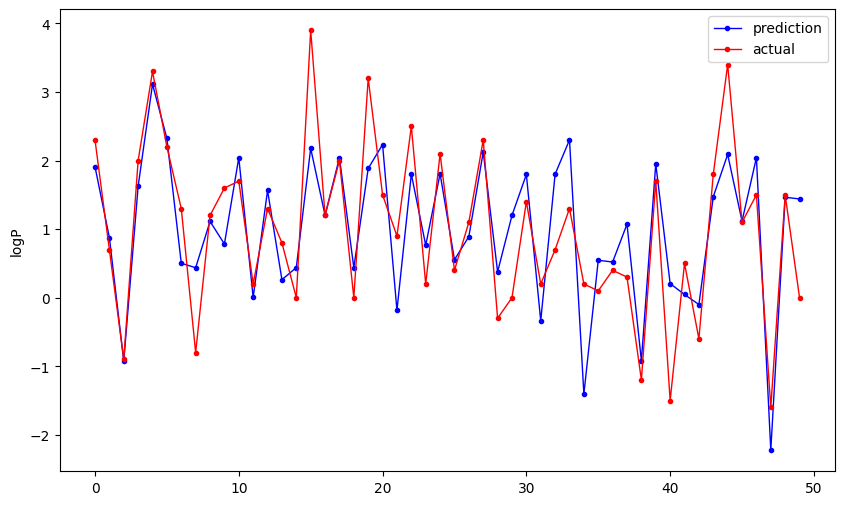

In [ ]:
# 모델 학습 및 성능 평가
lin = LinearRegression() # y = ax + b
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test) # logP의 예측값
show_reg_result(y_test, y_pred)

### 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = \frac{1}{N} \sum |y_{i} - \hat{y}|$

$MSE = \frac{1}{N} \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1 - \frac{\sum(y_{i}-\hat{y})^{2}}{\sum(y_{i}-\bar{y})^{2}} = 1 - \frac{MSE}{Variance}$
 >  $y$ :  실제값, $\hat{y}$ :  예측치, $\bar{y}$ :  평균치


-  R-Squared
 - 회귀 성능의 기본적인 평가 지표
 - MSE를 분산으로 정규화한 값을 사용한다
 - R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

## 분자 특성 추가

- [rdkit.Chem.Descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html)이 제공하는 함수들을 사용하면 다양한 분자특성들을 알 수 있다. 아래의 특성을 추가하겠다

 - TPSA() - the surface sum over all polar atoms or molecules also including their attached hydrogen atoms;
 - ExactMolWt() - 정확한 몰 중량
 - NumValenceElectrons() - number of valence electrons (may illustrate general electronic density)
 - NumHeteroatoms() - general number of non-carbon atoms
 
- 이외에도 분자의 링정보를 보거나, 원자별로 결합 정보를 볼 수 있다
 - GetRingInfo(), GetAtoms(), GetBonds() 등을 사용

In [ ]:
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

- 특성을 추가했을 때의 성능을 비교하겠다

In [ ]:
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


In [ ]:
X_train.shape

(13149, 10)

R2: 0.7907
MAE: 0.4625
RMSE: 0.5932
Max error: 2.2606


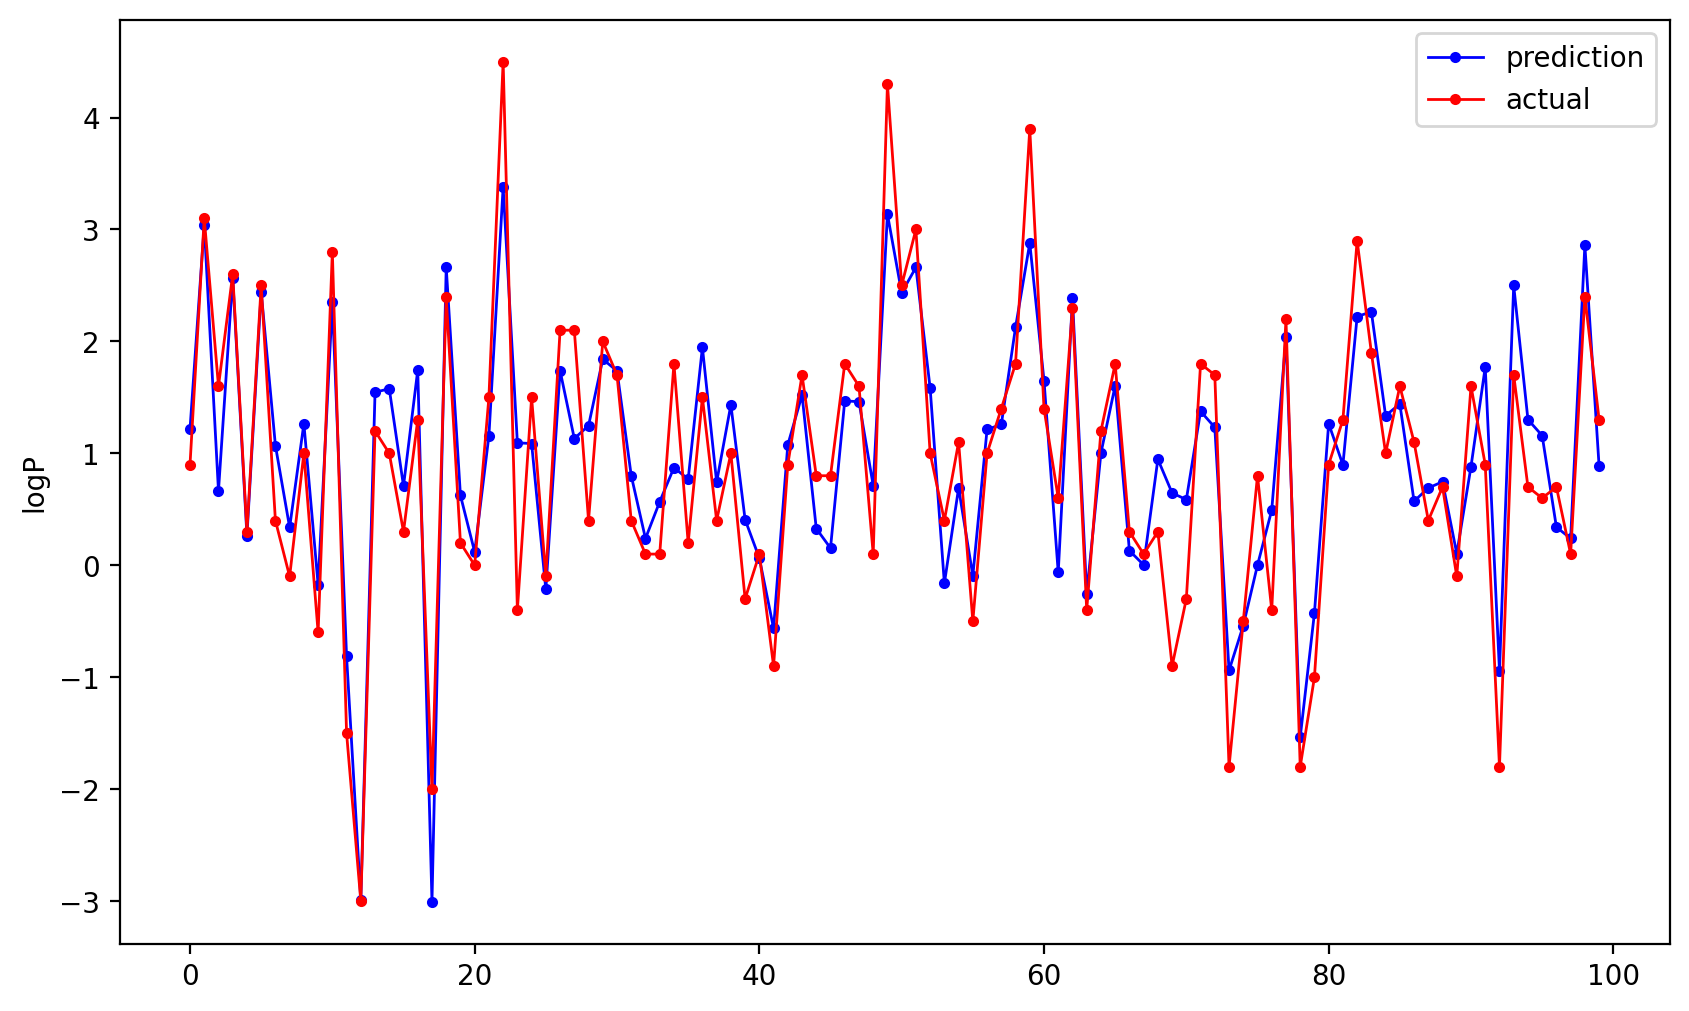

In [ ]:
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)
show_reg_result(y_test, y_pred,100)

In [ ]:
lin.coef_ # y = ax +b

array([-0.29776277, -0.60021523,  0.15722981, -0.03826434,  0.12643248,
        0.07375684, -0.03395185,  0.00498247,  0.26900081, -0.75744504])

In [ ]:
# 선형 모델 가중치를 보는 함수 정의

def plot_feature_weight(feature, weight):
    # plt.figure(figsize=(5,8)) # 특성수가 많은 경우
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

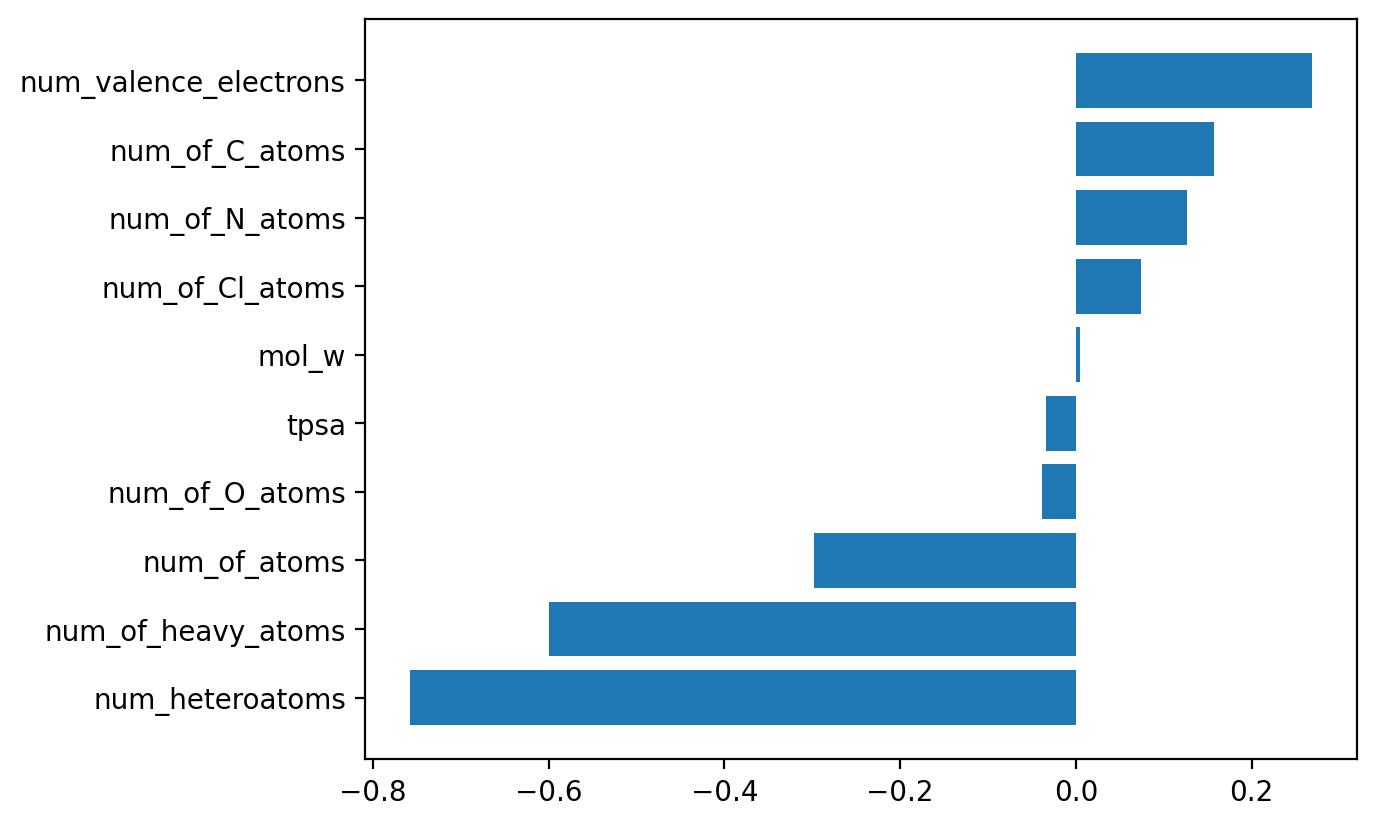

In [ ]:
plot_feature_weight(train_df.columns, lin.coef_)